# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинг и бэггинг

## Общая информация
Дата выдачи: 08.12.2020

Мягкий дедлайн: 19.12.2020 00:59 MSK

Жёсткий дедлайн: 21.12.2020 00:59 MSK

## Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

## Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия на латинице

## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг. Работать мы будем на двух наборах данных: многомерных данных по кредитам с kaggle и синтетических двумерных. В данных с kaggle целевая переменная показывает, вернуло ли кредит физическое лицо:

In [313]:
import numpy as np
import pandas as pd
import plotly.express as px

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, log_loss, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.utils import resample

In [ ]:
#!wget  -O 'bank_data.csv' -q 'https://www.dropbox.com/s/uy27mctxo0gbuof/bank_data.csv?dl=0'

In [2]:
df = pd.read_csv('bank_data.csv')
df.sample(5)

age         job  marital            education  default housing loan  \
682    27    services   single          high.school  unknown      no   no   
2188   30  technician   single    university.degree       no      no   no   
3218   38  technician  married  professional.course  unknown     yes   no   
8675   64      admin.  married          high.school       no     yes   no   
7565   55     unknown  married    university.degree       no     yes   no   

        contact month day_of_week  ...  campaign  pdays  previous  \
682   telephone   may         thu  ...         2    999         0   
2188   cellular   jul         tue  ...         1    999         0   
3218   cellular   nov         wed  ...         2    999         0   
8675   cellular   oct         fri  ...         1    999         1   
7565   cellular   aug         wed  ...         1    999         0   

         poutcome emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  \
682   nonexistent          1.1          93.994          -36.4      4.860   
2188  nonexistent          1.4          93.918          -42.7      4.962   
3218  nonexistent         -0.1          93.200          -42.0      4.120   
8675      failure         -3.4          92.431          -26.9      0.730   
7565  nonexistent         -2.9          92.201          -31.4      0.854   

      nr.employed  y  
682        5191.0 -1  
2188       5228.1 -1  
3218       5195.8 -1  
8675       5017.5  1  
7565       5076.2  1  

[5 rows x 21 columns]

Разделим на train и test (random_state не меняем)

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

Генерируем синтетические данные (seed не меняем)

In [4]:
np.random.seed(42)

num_obs = 10 ** 5
num_thresholds = 50

X_synthetic = np.random.normal(scale=3, size=[num_obs, 2])
x1_thresholds = np.random.choice(X_synthetic[:, 0], num_thresholds, False)
x2_thresholds = np.random.choice(X_synthetic[:, 1], num_thresholds, False)

gains = np.random.uniform(-0.4086, 0.5, size=[2 * num_thresholds, 1])
x1_thresholds_cond = [X_synthetic[:, 0] >= threshold for threshold in x1_thresholds]
x2_thresholds_cond = [X_synthetic[:, 1] >= threshold for threshold in x2_thresholds]

noise = np.random.uniform(-0.5, 0.5, size=num_obs)

y_synthetic_probits = np.sum(
    gains[:num_thresholds] * x1_thresholds_cond + gains[num_thresholds:] * x2_thresholds_cond, axis=0
) + noise
y_synthetic = np.sign(y_synthetic_probits)

X_train_synthetic, y_train_synthetic = X_synthetic[:int(num_obs * 0.8)], y_synthetic[:int(num_obs * 0.8)]
X_test_synthetic, y_test_synthetic = X_synthetic[int(num_obs * 0.8):], y_synthetic[int(num_obs * 0.8):]

px.histogram(x = y_synthetic_probits, nbins=100)

Некоторый полезный код для визуализации предсказаний (пригодится позже)

In [5]:
import matplotlib.pyplot as plt

def plot_predicts(model, features, targets, x_lim=[-15.0, 15.0], y_lim=[-15.0, 15.0],
                  examples_density=0.01, steps=1000, num_ticks=6, title='', mode='classification'):
    '''
    Функция для визуализации предсказаний модели на двухмерной плоскости
    param model: обученная модель классификации или регрессии для двухмерных объектов
    param features: признаки выборки (a.k.a. X)
    param targets: целевая переменная выборки (a.k.a y)
    param x_lim: пределы для x
    param y_lim: пределы для y
    param examples_density: доля выборки, которая будет нарисована
    param steps: частота разбиения плоскости
    param num_ticks: число подписей на графике
    param title: заголовок графика
    param mode: режим 'classification' - вероятности положительного класса
                режим 'regression' - вещественная целевая переменная
    '''
    
    mask = np.random.choice([True, False], size=features.shape[0], 
                            p=[examples_density, 1.0 - examples_density])
    features_x = (features[mask, 0] - x_lim[0]) / (x_lim[1] - x_lim[0]) * steps
    features_y = (features[mask, 1] - y_lim[0]) / (y_lim[1] - y_lim[0]) * steps
    
    xs = np.linspace(x_lim[0], x_lim[1], steps)
    ys = np.linspace(y_lim[0], y_lim[1], steps)
    
    xs, ys = np.meshgrid(xs, ys)
    grid = np.stack([xs.flatten(), ys.flatten()], axis=1)
    if mode == 'classification':
        predicts = model.predict_proba(grid)[:, 1].reshape(steps, steps)
        values = (targets[mask] == 1).astype(np.float)
    elif mode == 'regression':
        predicts = model.predict(grid).reshape(steps, steps)
        values = targets[mask]
    else:
        raise ValueError('Unknown mode')
    
    plt.figure(figsize=(10, 10))
    plt.imshow(predicts, origin='lower')
    plt.scatter(features_x, features_y, c=values, edgecolors='white', linewidths=1.5)
    plt.colorbar()
    
    plt.xticks(np.linspace(0, steps, num_ticks), np.linspace(x_lim[0], x_lim[1], num_ticks))
    plt.yticks(np.linspace(0, steps, num_ticks), np.linspace(y_lim[0], y_lim[1], num_ticks))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(title)
    plt.grid()
    plt.show()

#### 1. (4 балла) Реализуйте бустинг для задачи бинарной классификации.

Поскольку градиентный бустинг обучается через последовательное создание моделей, может получиться так, что оптимальная с точки зрения генерализации модель будет получена на промежуточной итерации. Обычно для контроля такого поведения в методе `fit` передается также валидационная выборка, по которой можно оценивать общее качество модели в процессе обучения (желательно делать это каждую итерацию, но если ваша имплементация слишком медленная или ваше железо не тянет, можно делать это реже). Кроме того, нет смысла обучать действительно глубокую модель на 1000 деревьев и больше, если оптимальный ансамбль получился, к примеру, на 70 итерации и в течение какого-то количества итераций не улучшился - поэтому мы также задействуем early stopping при отсутствии улучшений в течение некоторого числа итераций.

In [481]:
class Boosting:
    
    def __init__(
        self,
        base_model_class=DecisionTreeRegressor,
        base_model_params: dict={'max_features': 0.1},
        n_estimators: int=10,
        learning_rate: float=0.1,
        subsample: float=0.3,
        random_seed: int=228,
        custom_loss: list or tuple=None,
        use_best_model: bool=False,
        n_iter_early_stopping: int=None,
        eval_set: list or tuple=None
    ):
        
        # Класс базовой модели
        self.base_model_class = base_model_class
        # Параметры для инициализации базовой модели
        self.base_model_params = base_model_params
        # Число базовых моделей
        self.n_estimators = n_estimators
        # Длина шага (которая в лекциях обозначалась через eta)
        self.learning_rate = learning_rate
        # Доля объектов, на которых обучается каждая базовая модель
        self.subsample = subsample
        # seed для бутстрапа, если хотим воспроизводимость модели
        self.random_seed = random_seed
        # Использовать ли при вызове predict и predict_proba лучшее
        # с точки зрения валидационной выборки число деревьев в композиции
        self.use_best_model = use_best_model
        # число итераций, после которых при отсутствии улучшений на валидационной выборке обучение завершается
        self.n_iter_early_stopping = n_iter_early_stopping
        
        # Плейсхолдер для нулевой модели
        self.initial_model_pred = None
        
        # Список для хранения весов при моделях
        self.gammas = []
        
        # Создаем список базовых моделей
        self.models = [self.base_model_class(**self.base_model_params) for _ in range(self.n_estimators)]
        
        self.eval_set = eval_set
        # Если используем свою функцию потерь, ее нужно передать как список из loss-a и его производной
        if custom_loss is not None:
            self.loss_fn, self.loss_derivative = custom_loss
        else:
            self.sigmoid = lambda z: 1 / (1 + np.exp(-z))
            self.loss_fn = lambda y, z: -np.log(self.sigmoid(y * z)).mean()
            self.loss_derivative = lambda y, z: -y * self.sigmoid(-y * z)
        
        if self.use_best_model:
            self.change_cnt = 0
            
        self.classes_ = [0,1]
        
    def _fit_new_model(self, X: np.ndarray, y: np.ndarray or list, n_model: int, a_n):
        """
        Функция для обучения одной базовой модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :param n_model: номер модели, которую хотим обучить
        :param a_n: текущая сумма предсказаний модели
        """
        sub_idx = np.random.choice(X.shape[0], int(X.shape[0] * self.subsample))
        sub_X, sub_y = X[sub_idx], y[sub_idx]
        sub_a_n = a_n[sub_idx]        
        self.models[n_model].fit(sub_X, -self.loss_derivative(sub_y, sub_a_n))
        
    def _fit_initial_model(self, X, y):
        """
        Функция для построения нулевой (простой) модели. Не забудьте взять логарифм, потому что сигмоида применяется
        уже к сумме предсказаний базовых моделей, а не к каждому предсказанию каждой модели по отдельности.
        Подойдёт константная модель, возвращающая самый популярный класс,
        но если хотите, можете сделать что-нибудь посложнее.
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        logodds = np.log(np.sum(y==1) / np.sum(y != 1))
        self.initial_model_pred = lambda x : np.full(x.shape[0], logodds)
        
    def _find_optimal_gamma(self, y: np.ndarray or list, old_predictions: np.ndarray,
                            new_predictions: np.ndarray, boundaries: tuple or list=(0.01, 1)):
        """
        Функция для поиска оптимального значения параметра gamma (коэффициент перед новой базовой моделью).
        :param y: вектор целевой переменной
        :param old_predictions: вектор суммы предсказаний предыдущих моделей (до сигмоиды)
        :param new_predictions: вектор суммы предсказаний новой модели (до сигмоиды)
        :param boundaries: в каком диапазоне искать оптимальное значение ɣ (array-like объект из левой и правой границ)
        """
        # Определеяем начальные лосс и оптимальную гамму
        loss, optimal_gamma = self.loss_fn(y, old_predictions), 0
        # Множество, на котором будем искать оптимальное значение гаммы
        gammas = np.linspace(*boundaries, 100)
        # Простым перебором ищем оптимальное значение
        for gamma in gammas:
            predictions = old_predictions + gamma * new_predictions
            gamma_loss = self.loss_fn(y, predictions)
            if gamma_loss < loss:
                optimal_gamma = gamma
                loss = gamma_loss
        
        return optimal_gamma
        
        
    def fit(self, X, y, eval_set=None):
        """
        Функция для обучения всей модели бустинга
        :param X: матрица признаков
        :param y: вектор целевой переменной
        :eval_set: кортеж (X_val, y_val) для контроля процесса обучения или None, если контроль не используется
        """
        
        if self.eval_set is not None and eval_set is None:
            eval_set = self.eval_set
        np.random.seed(self.random_seed)
        self._fit_initial_model(X, y)
        old_pred = self.initial_model_pred(X)
        if self.use_best_model and eval_set is not None:
            X_val, y_val = eval_set
            old_val_pred = self.initial_model_pred(X_val)
            prev_classes = (self.sigmoid(old_val_pred) > 0.5) * 1
            prev_accuracy = accuracy_score((y_val == 1), prev_classes)

        for n in range(self.n_estimators):
            self._fit_new_model(X, y, n, old_pred)
#             sub_idx = np.random.choice(X.shape[0], int(X.shape[0] * self.subsample))
#             sub_X, sub_y = X[sub_idx], y[sub_idx]
#             sub_a_n = old_pred[sub_idx]
#             self.models[n].fit(sub_X, -self.loss_derivative(sub_y, sub_a_n))
            
            preds = self.models[n].predict(X)
            gamma = self._find_optimal_gamma(y, old_pred, preds)
            self.gammas.append(gamma)
            old_pred += preds * gamma * self.learning_rate

            if self.use_best_model and eval_set is not None:
                old_val_pred += self.models[n].predict(X_val) * gamma * self.learning_rate
                new_classes = (self.sigmoid(old_val_pred) > 0.5) * 1
                new_accuracy = accuracy_score((y_val == 1), new_classes)
                if new_accuracy <= prev_accuracy:
                    self.change_cnt += 1
                else:
                    self.change_cnt = 0
                prev_accuracy = new_accuracy
                if self.change_cnt == self.n_iter_early_stopping:
                    self.n_estimators = n + 1
                    self.models = self.models[:self.n_estimators]
                    break                
        return self
        
    def predict(self, X: np.ndarray):
        """
        Функция для предсказания классов обученной моделью бустинга
        :param X: матрица признаков
        """
        proba = self.predict_proba(X)[:,1]
        return (proba > 0.5) * 1
    
    def predict_proba(self, X: np.ndarray):
        """
        Функция для предсказания вероятностей классов обученной моделью бустинга
        :param X: матрица признаков
        """
        
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:
        logodds = self.initial_model_pred(X)
        for model, gamma in zip(self.models, self.gammas):
            logodds += model.predict(X) * gamma * self.learning_rate
        return np.column_stack((1-self.sigmoid(logodds), self.sigmoid(logodds)))
    
    def get_params(self, deep=True):
        return {'base_model_class':self.base_model_class, 'base_model_params':self.base_model_params,
               'n_estimators':self.n_estimators, 'learning_rate':self.learning_rate,
               'subsample':self.subsample, 'random_seed':self.random_seed,
               'use_best_model':self.use_best_model,
                'n_iter_early_stopping':self.n_iter_early_stopping, 'eval_set':self.eval_set
               }
    
    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
        
    @property
    def feature_importances_(self):
        """
        Для бонусного задания номер 5.
        Функция для вычисления важностей признаков.
        Вычисление должно проводиться после обучения модели
        и быть доступно атрибутом класса. 
        """
        # Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### Тест для вашей имплементации. Если класс написан правильно, две следующие ячейки должна отработать без ошибок и относительно быстро (у автора задания 2 и 0.2 секунд соответственно, accuracy 0.911 и 0.879 соответственно). Если у вас получилось качество выше указанного — отлично!

In [347]:
%%time

boosting = Boosting()
boosting.fit(X_train_synthetic, y_train_synthetic)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(X_test_synthetic) > 0.5)
print("accuracy = %.4f" % accuracy_score((y_test_synthetic == 1), np.round(preds)))
assert accuracy_score((y_test_synthetic == 1), np.round(preds)) > 0.9

accuracy = 0.9087
Wall time: 5.02 s


In [484]:
%%time

boosting = Boosting()
boosting.fit(df_train.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train.y.values)
# Без разницы, выдает эта строка классы или вероятности
preds = np.round(boosting.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values) > 0.5)
print("accuracy = %.4f" % accuracy_score((df_test.y.values == 1), np.round(preds)))
assert accuracy_score((df_test.y.values == 1), np.round(preds)) > 0.87

accuracy = 0.8847
Wall time: 1.09 s


#### 2. (2 балла) Сравните результаты вашей имплементации бустинга с указанными ниже базовыми моделями на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных. 

Варианты для базовой модели (разумеется, не надо их программировать самостоятельно, берите нужные классы из sklearn):

- Решающее дерево глубины 6
- Случайный лес (число деревьев — на ваше усмотрение, только не слишком мало)
- Линейная регрессия

Вопросы:

1) Какая из моделей имеет оптимальное качество? С чем это связано?

2) Какая из моделей сильнее переобучается? Есть ли преимущества от использования ранней остановки и обрезания бустинга до лучшей модели?

3) Работает ли бустинг над линейными регрессиями лучше, чем одна логистическая регрессия? Как объяснить этот результат?

4) Визуализируйте предсказания моделей на синтетическом датасете (для этого можете воспользоваться вспомогательной функцией plot_predicts). Чем отличаются картинки, которые получаются у разных алгоритмов? Сделайте выводы.

In [256]:
base_models_grid = [(DecisionTreeRegressor, {'max_depth':6}), 
                    (RandomForestRegressor,{'n_estimators':20}), 
                    (LinearRegression,{})]

In [291]:
X_train_synthetic_2, X_val_synthetic_2, y_train_synthetic_2, y_val_synthetic_2 = train_test_split(
    X_train_synthetic, y_train_synthetic, test_size=0.2, random_state=42)
df_train_2, df_val_2 = train_test_split(df_train, test_size=0.2, random_state=42)

In [349]:
res_2 = {}
synth_models_2 = []
n_estimators_2 = []

for base_model, base_params in base_models_grid:
    name = type(base_model()).__name__
    res_2[name] = []
    print(name)
    boosting = Boosting(base_model_class=base_model, base_model_params = base_params, 
                        use_best_model=True, n_iter_early_stopping=3, n_estimators = 20)
    boosting.fit(X_train_synthetic_2, y_train_synthetic_2, (X_val_synthetic_2, y_val_synthetic_2))
    synth_models_2.append(boosting)
    
    synth_train_pred = boosting.predict(X_train_synthetic_2)
    synth_pred = boosting.predict(X_test_synthetic)
    n_estimators_2.append([])
    n_estimators_2[-1].append(boosting.n_estimators)
    print('\tSynthetic data:')
    print('\tTrain accuracy: %.4f' % accuracy_score((y_train_synthetic_2 == 1), synth_train_pred), 
          'Test accuracy: %.4f' % accuracy_score((y_test_synthetic == 1), synth_pred))
    res_2[name].append([accuracy_score((y_train_synthetic_2 == 1), synth_train_pred), 
                        accuracy_score((y_test_synthetic == 1), synth_pred)])

    boosting2 = Boosting(base_model_class=base_model, base_model_params = base_params, 
                        use_best_model=True, n_iter_early_stopping=3, n_estimators = 20)
    boosting2.fit(df_train_2.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train_2.y.values, 
                 (df_val_2.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_val_2.y.values))
    credit_train_pred = boosting2.predict(df_train_2.select_dtypes(['int64', 'float64']).drop(columns='y').values)
    credit_pred = boosting2.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y'))
    n_estimators_2[-1].append(boosting2.n_estimators)
    print('\tCredit data:')
    print('\tTrain accuracy: %.4f' % accuracy_score((df_train_2.y.values == 1), credit_train_pred), 
          'Test accuracy: %.4f' % accuracy_score((df_test.y.values == 1), credit_pred))
    res_2[name].append([accuracy_score((df_train_2.y.values == 1), credit_train_pred),
                        accuracy_score((df_test.y.values == 1), credit_pred)])

DecisionTreeRegressor
	Synthetic data:
	Train accuracy: 0.9132 Test accuracy: 0.9141
	Credit data:
	Train accuracy: 0.8931 Test accuracy: 0.8901
RandomForestRegressor
	Synthetic data:
	Train accuracy: 0.9477 Test accuracy: 0.9169
	Credit data:
	Train accuracy: 0.9237 Test accuracy: 0.8917
LinearRegression
	Synthetic data:
	Train accuracy: 0.6916 Test accuracy: 0.6885
	Credit data:
	Train accuracy: 0.8336 Test accuracy: 0.8276


*1-2) Оптимальное качество наблюдается у случайного леса, что ожидаемо, поскольку случайный лес является композицией нескольких деревьев. Однако при его использовании бустинг переобучается больше всего, что можно объяснить тем, что глубина деревьев в лесе никак не ограничивается (а глубокие деревья имеют большой разброс и склонны к переобучению). На втором месте по качеству находится неглубокое дерево, которое также считается хорошей базовой моделью из-за простоты (к тому же, неглубокое дерево менее склонно к переобучению). Однако, как можно заметить, для крайне простых моделей как линейная регрессия, бустинг получается намного хуже, поскольку такие базовые модели будут плохо приближать вектор антиградиента.*

In [355]:
print('Number of base models in boosting:')
for i in range(3):
    print(type(base_models_grid[i][0]()).__name__)
    print('\tsynth data:', n_estimators_2[i][0], 'credit data:', n_estimators_2[i][1])

Number of base models in boosting:
DecisionTreeRegressor
	synth data: 11 credit data: 20
RandomForestRegressor
	synth data: 20 credit data: 20
LinearRegression
	synth data: 20 credit data: 6


*Как можно заметить, в некоторых моделях произошла остановка до окончания обучения всех базовых моделей (параметр `n_estimators` инициализировался значением 20). Преимущества у этого в том, что время работы у модели будет меньше, а также будет меньше тратиться памяти. Более того, при обучении бустинга стоит учитывать то, что после достижения оптимума на каком-то шаге модель может начать подстраиваться уже под шумы, поэтому стоит устанавливать критерий остановки.*

*3) Рассмотрим результаты логистической регресии:*

In [357]:
logr = LogisticRegression().fit(X_train_synthetic_2, y_train_synthetic_2)
print('synthetic data accuracy: %.4f' % accuracy_score(y_test_synthetic, logr.predict(X_test_synthetic)))
logr2 = LogisticRegression(max_iter=1000).fit(df_train_2.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train_2.y.values)
print('credit data accuracy: %.4f' % accuracy_score(df_test.y.values, logr2.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y').values)))

synthetic data accuracy: 0.6886
credit data accuracy: 0.8491


*Сравнив с результатом работы бустинга можем увидеть, что его результаты близки к результатам логистической регрессии (примерно 0.69 и 0.82-0.85 для двух датасетов). Объяснить это можно тем, что в бустинге используется по сути те же шаги, что и в логистической регрессии - минимизируется сигмоида от отступа. (Однако бустинг работает чуть хуже. Объяснить это можно тем, что линейная регрессия - довольно простая модель, из-за чего может неточно приближать вектор антиградиента и двигаться в направлении, отличном от направления наискорейшего убывания.)*

*4) Визуализируем предсказания для синтетического датасета:*

DecisionTreeRegressor


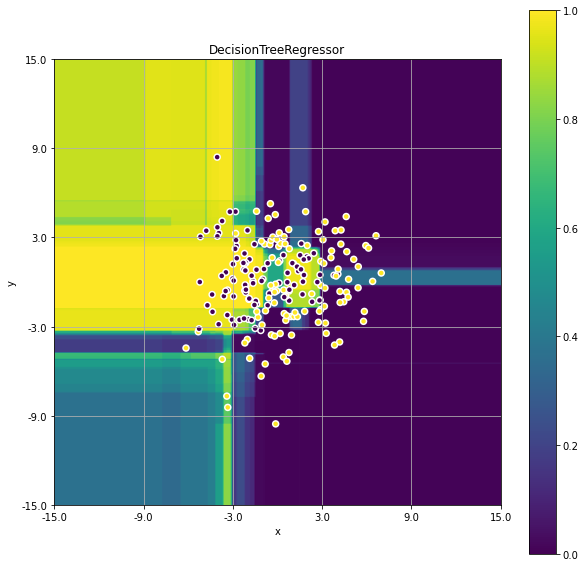

RandomForestRegressor


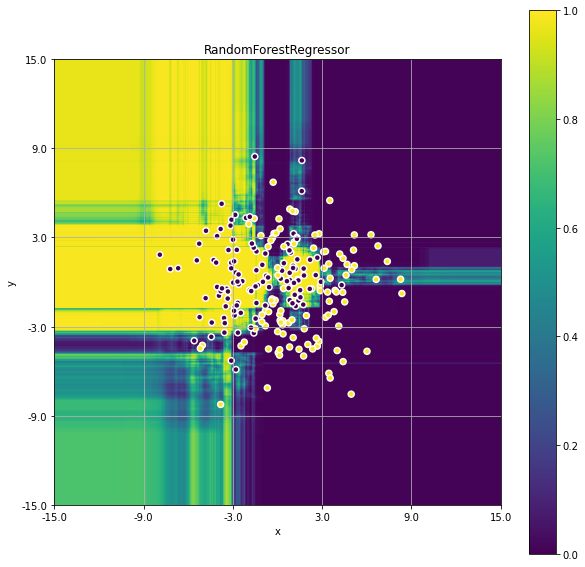

LinearRegression


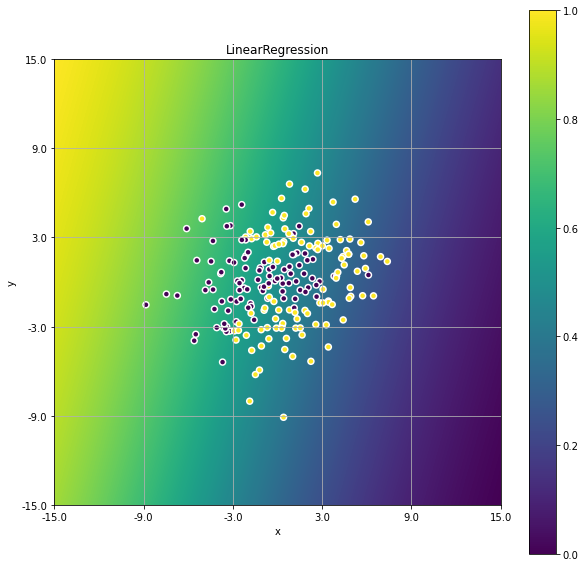

In [353]:
for i in range(3):
    plot_predicts(synth_models_2[i], X_test_synthetic, y_test_synthetic, title=type(base_models_grid[i][0]()).__name__)

*По графикам можно увидеть, что результаты для леса и решающего дерева довольно похожи, тогда как для линейной модели распределение вероятностей другое (например, левый нижний угол "более жёлтый" - имеет большую вероятность принадлежности рассматриваемому классу). Очевидно, разбиение в случайном лесе подробнее решающего дерева, поскольку для него не ставилось ограничение на глубину.*

#### 3. (2 балла) Мы разобрались с бустингом, теперь интересно посмотреть на совсем дикие комбинации моделей. Сравните результаты следующих моделей на обоих датасетах и ответьте на вопросы. Разумеется, надо измерять качество на тестовых данных.

Используйте логистическую регрессию, случайный лес и BaggingClassifier из sklearn.

- Случайный лес
- Бэггинг на деревьях (поставьте для базовых деревьев min_samples_leaf=1)
- Бэггинг на деревьях с обучением каждого дерева на подмножестве признаков (`max_features` около 0.6 в BaggingClassifier)
- Бэггинг, у которого базовой моделью является бустинг с большим числом деревьев (> 100)
- Бэггинг на логистических регрессиях

1) Какая из моделей имеет лучшее качество? С чем это связано?

2) Какая из моделей сильнее всего переобучается? Помогает ли бустингу ранняя остановка? 

3) Исправляет ли бэггинг переобученность бустинга с большим числом деревьев?

4) Что лучше: случайный лес или бэггинг на деревьях с сэмплированием признаков?

5) Если использовать деревья в качестве базового алгоритма, что лучше — бэггинг или бустинг? С чем это связано?

In [358]:
from sklearn.ensemble import BaggingClassifier

In [472]:
models_grid_3 = [(RandomForestClassifier(), 'RandomForest'), 
                 (BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=1)),'Bagging on DT'), 
                 (BaggingClassifier(max_features=0.6), 'Bagging on DT, max_ft=0.6'), 
                 (BaggingClassifier(base_estimator=Boosting(
                     n_estimators=500, n_iter_early_stopping=5, use_best_model=True,
                     eval_set=(X_val_synthetic_2, y_val_synthetic_2))),'Bagging on GB'), 
                 (BaggingClassifier(LogisticRegression(max_iter=1000)),'Bagging on LogReg')]
models_grid_3_2 = [(RandomForestClassifier(), 'RandomForest'), 
                 (BaggingClassifier(DecisionTreeClassifier(min_samples_leaf=1)),'Bagging on DT'), 
                 (BaggingClassifier(max_features=0.6), 'Bagging on DT, max_ft=0.6'), 
                 (BaggingClassifier(
                     base_estimator = Boosting(
                         n_estimators=500, n_iter_early_stopping=5, use_best_model=True,
                         eval_set = (
                             df_val_2.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_val_2.y.values))),
                  'Bagging on GB'), 
                 (BaggingClassifier(LogisticRegression(max_iter=1000)),'Bagging on LogReg')]

In [476]:
res_3 = {}
n_estimators_3 = []

for (model, name), (model2, name2) in zip(models_grid_3, models_grid_3_2):
    print(name)
    res_3[name] = []
    y_train_synthetic_2 = (y_train_synthetic_2 == 1) * 1
    model.fit(X_train_synthetic_2, y_train_synthetic_2)
    synth_train_pred = model.predict(X_train_synthetic_2)
    synth_pred = model.predict(X_test_synthetic)
    
    if (name == 'Bagging on GB'):
        n_estimators_3.append(model.base_estimator.n_estimators)

    print('\tSynthetic data:')
    print('\tTrain accuracy: %.4f' % accuracy_score((y_train_synthetic_2 == 1), synth_train_pred), 
          'Test accuracy: %.4f' % accuracy_score((y_test_synthetic == 1), synth_pred))
    res_3[name].append([accuracy_score((y_train_synthetic_2 == 1), synth_train_pred), 
                        accuracy_score((y_test_synthetic == 1), synth_pred)])

    model2.fit(df_train_2.select_dtypes(['int64', 'float64']).drop(columns='y').values, df_train_2.y.values == 1)
    credit_train_pred = (model2.predict(df_train_2.select_dtypes(['int64', 'float64']).drop(columns='y').values) == 1)
    credit_pred = (model2.predict(df_test.select_dtypes(['int64', 'float64']).drop(columns='y')) == 1)
    if (name == 'Bagging on GB'):
        n_estimators_3.append(model2.base_estimator.n_estimators)
    print('\tCredit data:')
    print('\tTrain accuracy: %.4f' % accuracy_score((df_train_2.y.values == 1), credit_train_pred), 
          'Test accuracy: %.4f' % accuracy_score((df_test.y.values == 1), credit_pred))
    res_3[name].append([accuracy_score((df_train_2.y.values == 1), credit_train_pred),
                        accuracy_score((df_test.y.values == 1), credit_pred)])

RandomForest
	Synthetic data:
	Train accuracy: 1.0000 Test accuracy: 0.9102
	Credit data:
	Train accuracy: 0.9998 Test accuracy: 0.8895
Bagging on DT
	Synthetic data:
	Train accuracy: 0.9926 Test accuracy: 0.9046
	Credit data:
	Train accuracy: 0.9880 Test accuracy: 0.8745
Bagging on DT, max_ft=0.6
	Synthetic data:
	Train accuracy: 0.9843 Test accuracy: 0.7216
	Credit data:
	Train accuracy: 0.9867 Test accuracy: 0.8653
Bagging on GB
	Synthetic data:
	Train accuracy: 0.7921 Test accuracy: 0.7817
	Credit data:
	Train accuracy: 0.5011 Test accuracy: 0.4860
Bagging on LogReg
	Synthetic data:
	Train accuracy: 0.6913 Test accuracy: 0.6887
	Credit data:
	Train accuracy: 0.8525 Test accuracy: 0.8464


*1, 4) Из результатов видно, что лучше всего сработал случайный лес - он безошибочно работает на обучающей выборке и имеет наилучшие результаты на тестовой (ясно, что деревья внутри леса хорошо подстраиваются под выборку, а преимущество этой модели над бэггингом - в частности, случайный лес лучше бэггинга над деревьями с сэмплированием признаков - в случайности при выборе предикатов для каждого дерева). В целом выведенные модели расположены в приблизительно убывающем по качеству порядке (за исключением случая использования бэггинга на деревьях, обучающихся на доле признаков, и бэггинга на бустинге на синтетическом датасете - на тестовой выборке для бэггинга над деревьями получается 0.7, над бустингом - 0.78).*

*2-3) Сильнее всего из моделей переобучается бэггинг на деревьях, обучающихся на доле признаков (около 1 на обучающей выборке и 0.7/0.87 на тестовых). Модель с бустингом не так сильно переобучается (разница в 0.01-0.02 между обучающими и тестовыми выборками), что значит, что остановка помогает модели. Этому также способствует использование бэггинга над бустингом - он усредняет значение разных моделей и тем самым делает модель менее переобученной.*

*5) При использовании в качестве базовых моделей деревьев лучше брать бустинг, если деревья неглубокие - таким образом бустинг сможет снизить смещение, а разброс будет изначально небольшим. Если же брать глубокие деревья, лучше использовать бэггинг - он смещение оставит таким же (а у глубоких деревьев они низкие), а разброс понизит (то есть снизит эффект переобучаемости глубоких деревьев).*

#### 4. (2 балла) Сравните на этих данных любую из трёх популярных имплементаций градиентного бустинга (xgboost, lightgbm, catboost) с вашей реализацией. Подберите основные гиперпараметры (число деревьев, длина шага, глубина дерева/число листьев) для обоих методов. Получилось ли у вас победить библиотечные реализации на тестовых данных?

__Бонус (1 балл)__: современное развитие методов машинного обучения позволяет автоматизировать и оптимизировать подбор гиперпараметров. Воспользуйтесь для данной задачи одним из фреймворков для такого подбора - например, [hyperopt](https://github.com/hyperopt/hyperopt) или [optuna](https://github.com/optuna/optuna). Сравните также полученные данным методом модели с простым перебором гиперпараметров. 

In [486]:
!pip install xgboost
import xgboost

In [501]:
n_est_grid = np.arange(10,20,5)
lr_grid = np.linspace(0,1,3)
max_depth_grid=np.arange(3,6,1)

In [502]:
from xgboost import XGBClassifier
best_xgb = None
best_xgb_score = 0
best_boosting = None
best_score = 0
for n in n_est_grid:
    for lr in lr_grid:
        for max_d in max_depth_grid:
            xgb = XGBClassifier(use_label_encoder=False,n_estimators=n,max_depth=max_d, learning_rate=lr).fit(X_train_synthetic_2, (y_train_synthetic_2 == 1))
            xgb_score = accuracy_score(xgb.predict(X_test_synthetic), y_test_synthetic)
            
            boosting = Boosting(n_estimators=n, base_model_params={'max_depth':max_d}, learning_rate = lr).fit(X_train_synthetic_2, (y_train_synthetic_2 == 1) * 1)
            score = accuracy_score(boosting.predict(X_test_synthetic), y_test_synthetic)
            
            if (score > best_score):
                best_score = score
                best_boosting = boosting
            if (xgb_score > best_xgb_score):
                best_xgb_score = xgb_score
                best_xgb = xgb

[00:50:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:50:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:51:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

In [503]:
print('My boosting accuracy: %.4f' % best_score)
print('XGB accuracy: %.4f' % best_xgb_score)

My boosting accuracy: 0.5072
XGB accuracy: 0.4744


*Выведем параметры отобранных моделей*

In [505]:
best_boosting.get_params()

{'base_model_class': sklearn.tree._classes.DecisionTreeRegressor,
 'base_model_params': {'max_depth': 3},
 'n_estimators': 10,
 'learning_rate': 0.5,
 'subsample': 0.3,
 'random_seed': 228,
 'use_best_model': False,
 'n_iter_early_stopping': None,
 'eval_set': None}

In [507]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 1.0,
 'max_delta_step': 0,
 'max_depth': 5,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 15,
 'n_jobs': 4,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

#### 5. (Бонус, 1 балл) В этом задании мы поговорим об интерпретации моделей.

Наша бустинговая модель способна возвращать вероятности для классов. Давайте попробуем оценить, насколько эти вероятности согласованы с реальностью. Для этого мы используем уже знакомый вам метод калибровочных кривых. Постройте калибровочные кривые для бустинговой модели и для логистической регрессии на обоих датасетах. Хорошо ли откалиброваны вероятности бустинга?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Бустинг также позволяет рассчитать важность признаков в данных. Для этого существует много подходов, но мы обратимся к самому простому. Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить, после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так). Проделайте это, затем нарисуйте столбчатые диаграммы важности признаков для обоих датасетов. На соседних графиках нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Что можно сказать?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (на тех же параметрах!). Стало ли лучше?

In [ ]:
# Your code here ╰( ͡° ͜ʖ ͡° )つ──☆*:

#### 6. (Бонус, 0.01 балла) Готовы ли вы в следующем году пойти ассистентом на этот курс и токсить на набор 19 года во флуде? 

*Увы, я умею хорошо токсить только на себя ┌(▀Ĺ̯ ▀-͠ )┐*